# Supplementary material

## Supplementary methods

Here you might include a description of the methods used in obtaining and analysing the data before getting into this document, e.g. how sequencing data was aligned and counted.

## Supplementary tables and figures

In [1]:
def get_geodata(GEO_ID):
    from urllib import request
    from Bio import Geo
    import gzip as gz
    ftp_url = f"https://ftp.ncbi.nlm.nih.gov/geo/series/{GEO_ID[0:5]}nnn/{GEO_ID}/soft/{GEO_ID}_family.soft.gz"
    request.urlretrieve(ftp_url, f"{GEO_ID}.gz")
    fh = gz.open(f"{GEO_ID}.gz", 'rt')
    records = Geo.parse(fh)
    geo_id_dict = {}
    for r in records:
        if r.entity_type == "SAMPLE":
            ID = r.entity_id
            name = r.entity_attributes['Sample_source_name_ch1']
            title = r.entity_attributes['Sample_title']
            geo_id_dict[ID] = {"name": name, "title": title}
    df = pd.DataFrame(geo_id_dict).T
    return df

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('pdf', 'svg')

In [4]:
counts_file="results/tables/counts.tsv"
summary_file="results/tables/counts.tsv.summary"
multiqc_file="intermediate/multiqc_general_stats.txt"
rulegraph_file="results/rulegraph.png"
SRR_IDs=["SRR935090","SRR935091","SRR935092"]
GSM_IDs=["GSM1186459","GSM1186460","GSM1186461"]
GEO_ID="GSE48896"

In [6]:
id_df = pd.DataFrame(data=GSM_IDs, index=SRR_IDs, columns=["geo_accession"])
geo_df = get_geodata(GEO_ID)
name_df = pd.merge(id_df, geo_df, left_on="geo_accession", right_index=True)
# Create a dictionary to rename sample ids in downstream plots
name_dict = name_df.to_dict()

In [7]:
name_df

,geo_accession,name,title
SRR935090,GSM1186459,Staphylococcus aureus RN4220,RN4220_empty
SRR935091,GSM1186460,Staphylococcus aureus RN4220,RN4220_ORF67
SRR935092,GSM1186461,Staphylococcus aureus NCTC8325-4,NCTC8325-4


In [8]:
qc = pd.read_csv(multiqc_file, sep="\t")
qc.rename(columns=lambda x: x.replace("FastQC_mqc-generalstats-fastqc-", "").replace("_", " "), inplace=True)
qc = pd.merge(qc, name_df, left_on="Sample", right_index=True)
qc

,Sample,percent duplicates,percent gc,avg sequence length,percent fails,total sequences,geo_accession,name,title
0,SRR935090,22.992,38.0,51.0,9.090909,25000.0,GSM1186459,Staphylococcus aureus RN4220,RN4220_empty
1,SRR935091,37.764,39.0,51.0,9.090909,25000.0,GSM1186460,Staphylococcus aureus RN4220,RN4220_ORF67
2,SRR935092,9.308,36.0,51.0,9.090909,25000.0,GSM1186461,Staphylococcus aureus NCTC8325-4,NCTC8325-4


In [9]:
# Read count data
counts = pd.read_csv(counts_file, sep="\t", header=0, comment="#", index_col=0)
# Read summary data
counts_summary = pd.read_csv(summary_file, sep="\t", index_col=0)
# Rename columns to extract SRR ids
counts.rename(columns = lambda x: x.split("/")[-1].replace(".sorted.bam",""), inplace=True)
counts_summary.rename(columns = lambda x: x.split("/")[-1].replace(".sorted.bam",""), inplace=True)

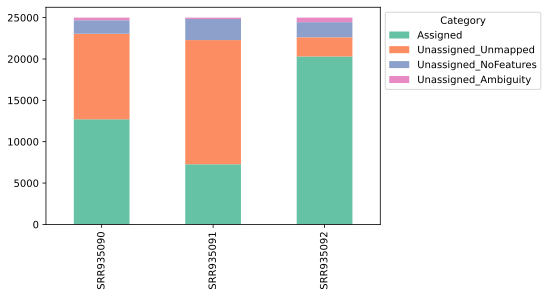

In [13]:
# Remove rows with only zero values
summary_plot_data = counts_summary.loc[counts_summary.sum(axis=1)>0]

# Set color palette to 'Set2'
colors = sns.color_palette("Set2")
# Create a stacked barplot
ax = summary_plot_data.T.plot(kind="bar", stacked=True, color=colors)
# Move legend and set legend title
ax.legend(bbox_to_anchor=(1,1), title="Category");

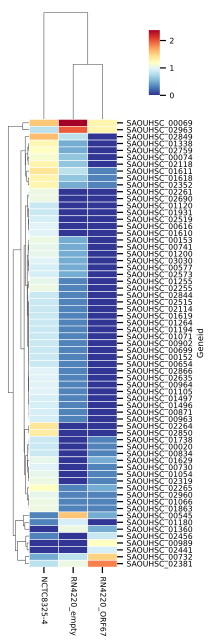

In [16]:
# Slice the dataframe to only sample counts
count_data = counts.loc[:, SRR_IDs]
# Filter to genes with std/mean > 1.2 and with a max of at least 5
heatmap_data = count_data.loc[(count_data.std(axis=1).div(count_data.mean(axis=1))>1.2)&(count_data.max(axis=1)>5)]
heatmap_data = heatmap_data.rename(columns = name_dict['title'])

with sns.plotting_context("notebook", font_scale=0.7):
    ax = sns.clustermap(data=np.log10(heatmap_data+1), cmap="RdYlBu_r", 
                        method="complete", yticklabels=True, linewidth=.5,
                        cbar_pos=(.7, .85, .05, .1), figsize=(3,9))
    plt.setp(ax.ax_heatmap.get_xticklabels(), rotation=270)

## Reproducibility

The code for reproducing this analysis is available in this [Richie GitHub repo](https://github.com/Richiewitty/git_tutorial).
The repo contains:

* A Snakemake workflow for running all analysis steps
* A Conda environment file for installing all needed dependenciesx
* A Docker file for running the analysis in a well-defined and isolated system

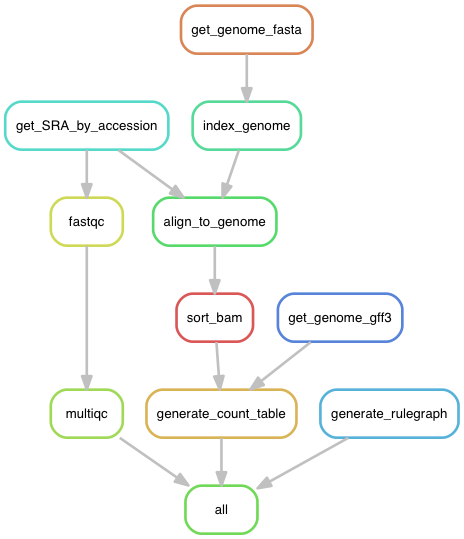

In [18]:
from IPython.display import Image
Image(rulegraph_file)

In [19]:
!conda list

# packages in environment at /home/dinesh/miniconda3/envs/jupyter-env:
#
# Name                    Version                   Build  Channel
_libgcc_mutex             0.1                 conda_forge    conda-forge
_openmp_mutex             4.5                       1_gnu    conda-forge
alsa-lib                  1.2.3                h516909a_0    conda-forge
argon2-cffi               21.1.0           py39h3811e60_2    conda-forge
attrs                     21.2.0             pyhd8ed1ab_0    conda-forge
backcall                  0.2.0              pyh9f0ad1d_0    conda-forge
backports                 1.0                        py_2    conda-forge
backports.functools_lru_cache 1.6.4              pyhd8ed1ab_0    conda-forge
biopython                 1.79             py39h3811e60_1    conda-forge
bleach                    4.1.0              pyhd8ed1ab_0    conda-forge
brotli                    1.0.9                h7f98852_6    conda-forge
brotli-bin                1.0.9                h7f988